In [29]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PowerTransformer
import math

In [3]:
# Downloads the below csv files to a local path
# corruption.csv, cost of living.csv, richest_countries.csv, tourism.csv, unemployment.csv
path = kagglehub.dataset_download("madhurpant/world-economic-data")

In [56]:
#creates a dictionary with files names as values and keys. The keys are used as dataframe names
df_dict = {'corruption':'corruption.csv',
           'col': 'cost_of_living.csv',
           'rich_countries':'richest_countries.csv',
           'tourism':'tourism.csv',
           'unemployment':'unemployment.csv'
            }

#iterates over the dictionary of files and creates data frames
# the globals() function assigns the key as the variable 
for key,value in df_dict.items():
    globals()[key] = pd.read_csv(f'{path}/{value}')

#creates a data frame that contains data frame name, file name, columns count, and row count per file
df_info = pd.DataFrame(columns=['Name','File', 'Column_Count', 'Row_Count'])
for key in df_dict.items():
    df = pd.DataFrame([key[0]], columns = ['Name'])
    df['File'] = key[1]
    df['Column_Count'] = globals()[key[0]].shape[1]
    df['Row_Count'] = globals()[key[0]].shape[0]
    df_info = pd.concat([df_info,df],ignore_index = True)


#creates a series of all countries
countries = pd.DataFrame(columns=['country'])
for key in df_dict.items():
    countries = pd.concat([countries,globals()[key[0]]],ignore_index = True)
countries = countries['country']
countries = countries.drop_duplicates(keep="first", inplace=False)

In [57]:
df_info

,Name,File,Column_Count,Row_Count
0,corruption,corruption.csv,3,110
1,col,cost_of_living.csv,4,107
2,rich_countries,richest_countries.csv,2,50
3,tourism,tourism.csv,5,41
4,unemployment,unemployment.csv,2,64


In [6]:
#there is a negative linear relationshop between annual income an corruption.
#as income increase corruption decreases
corruption.corr()

,annual_income,corruption_index
annual_income,1.000000,-0.916669
corruption_index,-0.916669,1.000000


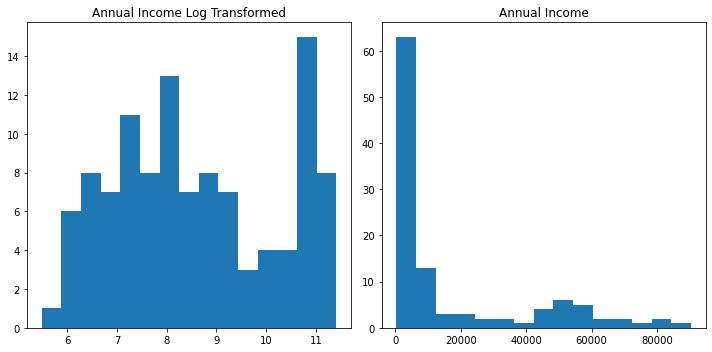

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

#axs[0].hist(corruption['corruption_index'], bins=15)
#axs[0].set_title('Corruption Index')

axs[1].hist(corruption['annual_income'], bins=15)
axs[1].set_title('Annual Income')

axs[0].hist(corruption['annual_income_log'], bins=15)
axs[0].set_title('Annual Income Log Transformed')

plt.tight_layout()
plt.show()

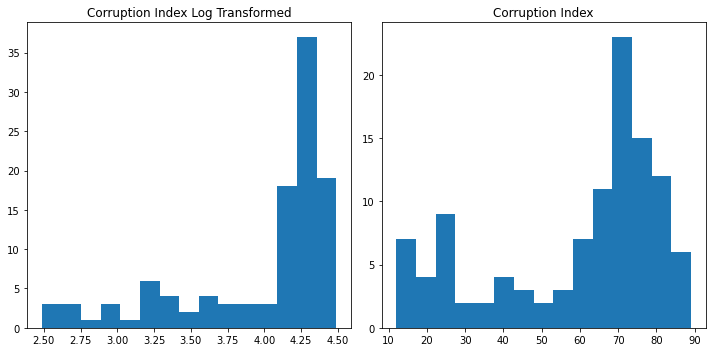

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[1].hist(corruption['corruption_index'], bins=15)
axs[1].set_title('Corruption Index')

axs[0].hist(corruption['corruption_index_log'], bins=15)
axs[0].set_title('Corruption Index Log Transformed')

plt.tight_layout()
plt.show()

In [61]:
#log transformations to use in the regression models
corruption['annual_income_log'] = np.log(corruption['annual_income'])
corruption['corruption_index_log'] = np.log(corruption['corruption_index'])

#power transformations to use in the regression models
pt = PowerTransformer()
annual_income_power = pd.Series(pt.fit_transform(corruption['annual_income'].to_numpy().reshape(-1, 1)).ravel(),name='annual_income_power')
corruption_index_power = pd.Series(pt.fit_transform(corruption['corruption_index'].to_numpy().reshape(-1, 1)).ravel(),name='corruption_index_power')

corruption = corruption.merge(corruption_index_power,how='left', left_index=True,right_index=True)
corruption = corruption.merge(annual_income_power,how='left', left_index=True,right_index=True)

,country,annual_income,corruption_index,annual_income_log,corruption_index_log,corruption_index_power,annual_income_power
0,Denmark,68110,12,11.128879,2.484907,-1.785202,1.487667
1,Finland,53660,12,10.890423,2.484907,-1.785202,1.362233
2,New Zealand,45340,12,10.721945,2.484907,-1.785202,1.272407
3,Norway,84090,15,11.339643,2.708050,-1.737767,1.596897
4,Singapore,64010,15,11.066795,2.708050,-1.737767,1.455200
...,...,...,...,...,...,...,...
105,Yemen,670,84,6.507278,4.430817,1.329489,-1.333215
106,Venezuela,13080,86,9.478840,4.454347,1.469925,0.577737
107,Somalia,450,87,6.109248,4.465908,1.541166,-1.618543
108,Syria,1170,87,7.064759,4.465908,1.541166,-0.945740


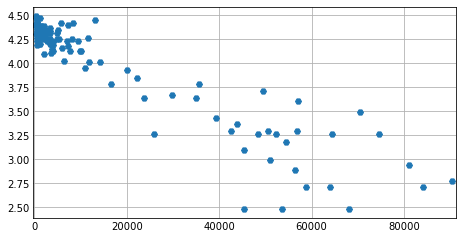

In [18]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(corruption['annual_income'],corruption['corruption_index_log'],marker="H")
plt.xlim(corruption['annual_income'].min()-500,corruption['annual_income'].max()+1000)
plt.show()

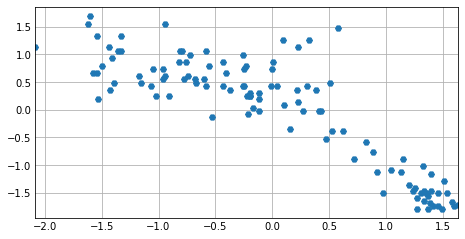

In [45]:
plt.style.use('_mpl-gallery')
fig, ax = plt.subplots(figsize=(6,3))
ax.scatter(annual_income_power,corruption_index_power,marker="H")
plt.xlim(annual_income_power.min(),annual_income_power.max())
plt.show()

In [88]:
#Training and testing arrays
#Creates a dataframe with results of each x and y combination

income_list = ['annual_income', 'annual_income_log','annual_income_power']
corruption_list = ['corruption_index','corruption_index_log','corruption_index_power']

corruption_model = pd.DataFrame(columns = ['x','y','r2','mse' ])

for inc in income:
    for corrupt in corruption_list:
        X_train, X_test, y_train, y_test = train_test_split(corruption[inc], 
                                                    corruption[corrupt], random_state=42)
        #converting the training and test data to arrays
        x = corruption[inc].to_numpy().reshape(-1,1)
        y = corruption[corrupt].to_numpy().reshape(-1,1)
        X_train = X_train.to_numpy().reshape(-1, 1)
        y_train = y_train.to_numpy().reshape(-1, 1)
        X_test = X_test.to_numpy().reshape(-1,1)
        y_test = y_test.to_numpy().reshape(-1,1)
        reg = LinearRegression().fit(X_train,y_train)
        df = pd.DataFrame(data=[corruption[inc].name],columns = ['x'])
        df['y'] = corruption[corrupt].name
        df['r2'] = round(reg.score(x,y),4)
        df['mse'] = round(mean_squared_error(y, reg.predict(x)),2)
        corruption_model = pd.concat([corruption_model,df],ignore_index = True)

In [89]:
#prints a data frame of r2 and mse per x and y combo
#the annual income independent variable and corruption index log dependent variable combo predicts the best
corruption_model

,x,y,r2,mse
0,annual_income,corruption_index,0.8397,78.05
1,annual_income,corruption_index_log,0.8521,0.04
2,annual_income,corruption_index_power,0.7737,0.23
3,annual_income_log,corruption_index,0.7637,115.09
4,annual_income_log,corruption_index_log,0.6934,0.09
5,annual_income_log,corruption_index_power,0.7646,0.24
6,annual_income_power,corruption_index,0.7342,129.44
7,annual_income_power,corruption_index_log,0.6603,0.1
8,annual_income_power,corruption_index_power,0.7407,0.26


In [102]:
inc = 'annual_income'
corrupt = 'corruption_index_log'

X_train, X_test, y_train, y_test = train_test_split(corruption[inc], 
                                                    corruption[corrupt], random_state=42)

x = corruption[inc].to_numpy().reshape(-1,1)
y = corruption[corrupt].to_numpy().reshape(-1,1)
X_train = X_train.to_numpy().reshape(-1, 1)
y_train = y_train.to_numpy().reshape(-1, 1)
X_test = X_test.to_numpy().reshape(-1,1)
y_test = y_test.to_numpy().reshape(-1,1)
reg = LinearRegression().fit(X_train,y_train)

In [109]:
#Uses the slope and intercept to calculate the predicted corruption index based on income
#Set the income variable to some value and execute the block for the result 

income = 3000

#uncomment or comment when non logarithmic transormed corruption index is used as the depended variable
#pred_corpt = round(reg.intercept_[0]+(reg.coef_[0][0]*income),0)

#comment or uncomment when the log corruption index is used as the dependent variable
pred_corpt = round(math.exp(reg.intercept_[0]+(reg.coef_[0][0]*income)),0)

print(f'The predicted corruption index is {pred_corpt}'),
print('Actual data for countries with a corruption index between -+3 of the predicted corruption index')
corruption[['country','annual_income','corruption_index']].loc[(corruption['corruption_index']>=pred_corpt-3)&(corruption['corruption_index']<=pred_corpt+3)] 

The predicted corruption index is 72.0
Actual data for countries with a corruption index between -+3 of the predicted corruption index


,country,annual_income,corruption_index
54,Gabon,7100,69
55,Mexico,9380,69
56,Niger,590,69
57,Papua New Guinea,2790,69
58,Azerbaijan,4880,70
59,Bolivia,3360,70
60,Djibouti,3300,70
61,Dominican Republic,8220,70
62,Kenya,2010,70
63,Laos,2520,70
